# Neural Style Transfer


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

### Computing the content cost

In [2]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, [n_H*n_W, n_C])
    a_G_unrolled =  tf.reshape(a_G, [n_H*n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/(4*n_H*n_W*n_C)) * tf.reduce_sum((a_C_unrolled - a_G_unrolled)**2)
    
    return J_content

###  Computing the style cost

In [3]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [4]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S), [n_C, n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G), [n_C, n_H*n_W])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = 1/((2*n_H*n_W*n_C)**2) * tf.reduce_sum((GS-GG)**2)
        
    return J_style_layer

In [5]:
# Style Weights
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name] # pre computing B)

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### Total cost to optimize

In [7]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

### Program

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG16 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.


In [8]:
# Reset the graph
tf.reset_default_graph()

#GPU configs (Optional)
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.25

#start the session
sess = tf.InteractiveSession(config=config)

(640, 640, 3)
(1, 640, 640, 3)


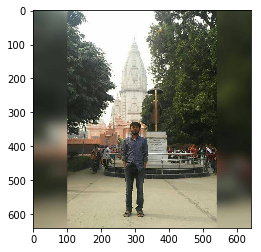

In [9]:
content_image = plt.imread('images/content.jpeg')
print(content_image.shape)
plt.imshow(content_image)
content_image = reshape_and_normalize_image(content_image)
print(content_image.shape)

(640, 640, 3)
(1, 640, 640, 3)


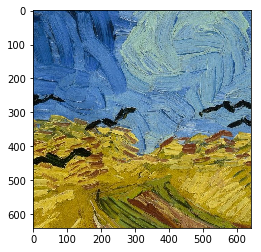

In [10]:
style_image = mpimg.imread("images/2-style.jpg")
print(style_image.shape)
plt.imshow(style_image)
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)

In [11]:
generated_image = generate_noise_image(content_image)
# plt.imshow(generated_image[0])

In [12]:
model = load_vgg_model("pretrained-model/vgg19.mat")

In [13]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out) #pre computing B)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

# compute the total cost
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

In [14]:
#nitializes the variables of the tensorflow graph, assigns the input image \
#(initial generated image) as the input of the VGG16 model and runs the train_step for a large number of steps.

def model_nn(sess, input_image, num_iterations = 1000):
    
    # Initialize global variables 
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%100 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [15]:
%%time
generated_image = model_nn(sess, generated_image)

Iteration 0 :
total cost = 4.98632e+09
content cost = 6275.42
style cost = 1.24656e+08
Iteration 100 :
total cost = 1.03356e+08
content cost = 17320.2
style cost = 2.57957e+06
Iteration 200 :
total cost = 3.61365e+07
content cost = 17460.1
style cost = 899048.0
Iteration 300 :
total cost = 1.71009e+07
content cost = 17550.8
style cost = 423134.0
Iteration 400 :
total cost = 8.81522e+06
content cost = 17643.7
style cost = 215970.0
Iteration 500 :
total cost = 5.20863e+06
content cost = 17736.5
style cost = 125782.0
Iteration 600 :
total cost = 3.54358e+06
content cost = 17832.7
style cost = 84131.3
Iteration 700 :
total cost = 2.65762e+06
content cost = 17915.4
style cost = 61961.7
Iteration 800 :
total cost = 2.12387e+06
content cost = 17989.4
style cost = 48599.5
Iteration 900 :
total cost = 1.78164e+06
content cost = 18049.6
style cost = 40028.7
CPU times: user 3min 50s, sys: 55.1 s, total: 4min 45s
Wall time: 8min 1s


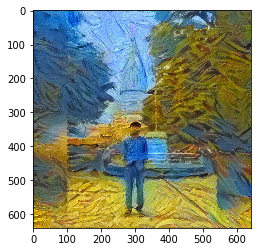

In [33]:
plt.imshow(mpimg.imread('output/generated_image.jpg'))

### References:

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
